In [ ]:
# import and install all libraries necessary for execution
import tensorflow as tf
import pandas as pd
import numpy as np
import scipy
from scipy import misc
import glob
from PIL import Image
import os
import matplotlib.pyplot as plt
import librosa
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.initializers import glorot_uniform
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
%pip install pydub
from pydub import AudioSegment
import shutil
from keras.preprocessing.image import ImageDataGenerator
import random
import librosa.display
import skimage
from pydub import AudioSegment

!pip install kaggle

# upload the kaggle.json file from computer
from google.colab import files
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! mkdir Data

# download and uzip the GTZAN dataset 
! kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification
! unzip gtzan-dataset-music-genre-classification.zip -d Data

# start making the directory to store all the audio files in
os.makedirs('/content/grive/My Drive/spectrograms3sec')

genres = 'blues classical country disco pop hiphop metal reggae rock'
genres = genres.split()

# audio3sec will now have 9 new folders, 1 for each genre
for g in genres:
  path = os.path.join('/content/audio3sec',f'{g}')
  os.makedirs(path)


In [ ]:
# we will be taking 1/8th of the origial dataset (i.e., oly 13 out of the 100 files from each genre)
newSong = 'newSong'
i = 0
for g in genres:
  j=0
  x=0
  print(f"{g}")
  for filename in os.listdir(os.path.join('/content/Data/Data/genres_original',f"{g}")):
    if x<13:
      x=x+1
      song  =  os.path.join(f'/content/Data/Data/genres_original/{g}',f'{filename}')
      j = j+1
      # splits each audio file into 10 audio files of 3 seconds each
      for w in range(0,10):
        i = i+1
        t1 = 3*(w)*130
        t2 = 3*(w+1)*130
        newAudio = AudioSegment.from_wav(song)
        new = newAudio[t1:t2]
        new.export(f'/content/audio3sec/{g}/{g+str(j)+str(w)}.wav', format="wav")

blues
classical
country
disco
pop
hiphop
metal
reggae
rock


In [ ]:
!zip -r /content/audio3sec.zip /content/audio3sec

  adding: content/audio3sec/ (stored 0%)
  adding: content/audio3sec/metal/ (stored 0%)
  adding: content/audio3sec/metal/metal102.wav (deflated 7%)
  adding: content/audio3sec/metal/metal85.wav (deflated 13%)
  adding: content/audio3sec/metal/metal55.wav (deflated 3%)
  adding: content/audio3sec/metal/metal50.wav (deflated 4%)
  adding: content/audio3sec/metal/metal15.wav (deflated 4%)
  adding: content/audio3sec/metal/metal93.wav (deflated 2%)
  adding: content/audio3sec/metal/metal34.wav (deflated 3%)
  adding: content/audio3sec/metal/metal63.wav (deflated 6%)
  adding: content/audio3sec/metal/metal118.wav (deflated 3%)
  adding: content/audio3sec/metal/metal62.wav (deflated 10%)
  adding: content/audio3sec/metal/metal78.wav (deflated 5%)
  adding: content/audio3sec/metal/metal56.wav (deflated 3%)
  adding: content/audio3sec/metal/metal59.wav (deflated 3%)
  adding: content/audio3sec/metal/metal11.wav (deflated 4%)
  adding: content/audio3sec/metal/metal110.wav (deflated 2%)
  addin

In [ ]:
# make train and test directories to store Mel-spectograms
os.makedirs('/content/gdrive/My Drive/spectrograms3sec/train')
os.makedirs('/content/gdrive/My Drive/spectrograms3sec/test')

In [ ]:
# these lines simply add all genre folders to train and test
for g in genres:
  path1 = os.path.join('/content/gdrive/My Drive/spectrograms3sec/train',f'{g}')
  os.makedirs(path1)

for g in genres:
  path2 = os.path.join('/content/gdrive/My Drive/spectrograms3sec/test',f'{g}')
  os.makedirs(path2)

blues
classical
country
disco
pop
hiphop
metal
reggae
rock


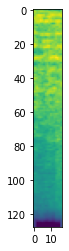

In [ ]:
for g in genres:
  j = 0
  print(g)
  for filename in os.listdir(os.path.join('/content/audio3sec',f"{g}")):
    song  =  os.path.join(f'/content/audio3sec/{g}',f'{filename}')
    j = j+1
    y,sr = librosa.load(song,duration=3)
    #print(sr)
    mels = librosa.feature.melspectrogram(y=y,sr=sr)
    fig = plt.Figure()
    canvas = FigureCanvas(fig)
    p = plt.imshow(librosa.power_to_db(mels,ref=np.max))
    plt.savefig(f'/content/gdrive/My Drive/spectrograms3sec/train/{g}/{g+str(j)}.png')

In [ ]:
# randomly choose 13 spectrograms files from train for test
directory = "/content/gdrive/My Drive/spectrograms3sec/train/"
for g in genres:
  filenames = os.listdir(os.path.join(directory,f"{g}"))
  random.shuffle(filenames)
  test_files = filenames[0:13]

  for f in test_files:

    shutil.move(directory + f"{g}"+ "/" + f,"/content/gdrive/My Drive/spectrograms3sec/test/" + f"{g}")

In [ ]:
# finds how many images and classes are present for both directories
train_dir = "/content/gdrive/My Drive/spectrograms3sec/train"
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir,target_size=(288,432),color_mode="rgba",class_mode='categorical',batch_size=128)

validation_dir = "/content/gdrive/My Drive/spectrograms3sec/test"
vali_datagen = ImageDataGenerator(rescale=1./255)
vali_generator = vali_datagen.flow_from_directory(validation_dir,target_size=(288,432),color_mode='rgba',class_mode='categorical',batch_size=128)

Found 1053 images belonging to 9 classes.
Found 117 images belonging to 9 classes.


In [ ]:
# the CNN model
def GenreModel(input_shape = (288,432,4),classes=9):
  np.random.seed(9)
  X_input = Input(input_shape)

  X1 = Conv2D(8,kernel_size=(3,3),strides=(1,1),kernel_initializer = glorot_uniform(seed=9))(X_input)
  X2 = BatchNormalization(axis=3)(X1)
  X3 = Activation('relu')(X2)
  X4 = MaxPooling2D((2,2))(X3)
  
  X5 = Conv2D(16,kernel_size=(3,3),strides = (1,1),kernel_initializer=glorot_uniform(seed=9))(X4)
  X6 = BatchNormalization(axis=3)(X5)
  X7 = Activation('relu')(X6)
  X8 = MaxPooling2D((2,2))(X7)
  
  X9 = Conv2D(32,kernel_size=(3,3),strides = (1,1),kernel_initializer = glorot_uniform(seed=9))(X8)
  X10 = BatchNormalization(axis=3)(X9)
  X11 = Activation('relu')(X10)
  X12 = MaxPooling2D((2,2))(X11)

  X13 = Conv2D(64,kernel_size=(3,3),strides=(1,1),kernel_initializer=glorot_uniform(seed=9))(X12)
  X14 = BatchNormalization(axis=-1)(X13)
  X15 = Activation('relu')(X14)
  X16 = MaxPooling2D((2,2))(X15)

  
  X17 = Flatten()(X16)

  X18 = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=9))(X17)

  model = Model(inputs=X_input,outputs=X18,name='GenreModel')

  return model

In [ ]:
# trains the CNN model by computing F1 score
import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
# config the model with learning rate and metrics
model = GenreModel(input_shape=(288,432,4),classes=9)
opt = Adam(learning_rate=0.0005)
model.compile(optimizer = opt,loss='categorical_crossentropy',metrics=['accuracy',get_f1])

In [ ]:
# show the performance metrics for 30 epochs
model.fit_generator(train_generator, epochs=30, validation_data=vali_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
9/9 [==============================] - 120s 12s/step - loss: 4.9326 - accuracy: 0.1061 - get_f1: 0.0417 - val_loss: 2.2070 - val_accuracy: 0.1111 - val_get_f1: 0.0000e+00
Epoch 2/30
9/9 [==============================] - 99s 11s/step - loss: 3.7091 - accuracy: 0.1198 - get_f1: 0.0708 - val_loss: 2.2074 - val_accuracy: 0.1111 - val_get_f1: 0.0000e+00
Epoch 3/30
9/9 [==============================] - 98s 11s/step - loss: 2.5600 - accuracy: 0.1783 - get_f1: 0.0594 - val_loss: 2.2126 - val_accuracy: 0.1282 - val_get_f1: 0.0000e+00
Epoch 4/30
9/9 [==============================] - 99s 11s/step - loss: 2.2217 - accuracy: 0.2553 - get_f1: 0.0610 - val_loss: 2.2266 - val_accuracy: 0.1197 - val_get_f1: 0.0000e+00
Epoch 5/30
9/9 [==============================] - 99s 11s/step - loss: 1.9044 - accuracy: 0.3063 - get_f1: 0.1183 - val_loss: 2.2450 - val_accuracy: 0.1111 - val_get_f1: 0.0000e+00
Epoch 6/30
9/9 [==============================] - 98s 11s/step - loss: 1.7782 - accuracy: 0.33

In [ ]:
pip install plot_keras_history

  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.29-cp37-none-any.whl size=8614 sha256=9883502a531e2c216a27250165a342328dda2e1c9249c673297055236eba064e
  Stored in directory: /root/.cache/pip/wheels/8b/cb/fb/cbeba24d72e736b8987b7d0dc37afc0e76f3c16e544ceff727
  Created wheel for sanitize-ml-labels: filename=sanitize_ml_labels-1.0.26-cp37-none-any.whl size=7610 sha256=6c7e435814f50d2a56feadde8b8fc2e197ded383817a20d8a6dfdead55fc4d5b
  Stored in directory: /root/.cache/pip/wheels/2a/62/31/d348320becc60729f508a2c5aad445b94d7543c5cb577cfb9d
  Created wheel for compress-json: filename=compress_json-1.0.4-cp37-none-any.whl size=4586 sha256=8c12bdab16a51b494b80ec437337788b5b4c928e0044e5c15f569709e0342c1b
  Stored in directory: /root/.cache/pip/wheels/83/ec/21/51460dd508e4a152c0643946c21fae84eb3391171164d35745
Successfully built plot-keras-history sanitize-ml-labels compress-json


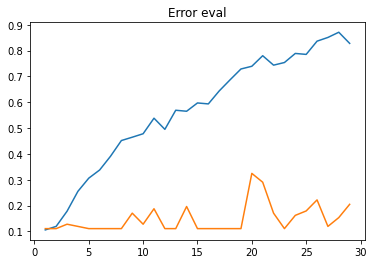

In [ ]:
x1 = [ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
y1 = [ 0.1061, 0.1198, 0.1783, 0.2553, 0.3063, 0.3379, 0.391, 0.4518, 0.4647, 0.4781, 0.5382, 0.4951, 0.569, 0.5651, 0.5972, 0.5935, 0.6437, 0.6867, 0.7286, 0.7391, 0.7799, 0.7434, 0.7536, 0.7887, 0.785, 0.8362, 0.8506, 0.8707, 0.8276]

x2 = [ 1, 2, 3, 4, 5, 6,7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
y2 = [0.1111, 0.1111, 0.1282, 0.1197, 0.1111,0.1111, 0.1111, 0.1111, 0.1709, 0.1282, 0.188, 0.1111, 0.1111, 0.1966, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.3248, 0.2906, 0.1709, 0.1111, 0.1624, 0.1795, 0.2222, 0.1197, 0.1538, 0.2051]

plt.plot(x1, y1, label = "line 1")
plt.plot(x2, y2, label = "line 1")

# giving a title to my graph
plt.title('Error eval')
  
# function to show the plot
plt.show()